the figure is Extended Data Fig 10c now

In [1]:
import os
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
import matplotlib.colors as mcolors
import networkx as nx
from matplotlib.lines import Line2D
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.style.use("ggplot")

In [3]:
def jaccard_similarity(list1, list2):
    intersection = len(set(list1).intersection(list2))
    union = (len(set(list1)) + len(set(list2))) - intersection
    return intersection / union

from itertools import product, starmap

In [4]:
def union2min(l1,l2):
    intersection = len(set(l1).intersection(l2))
    return intersection / min(len(l1),len(l2))

def union2max(l1,l2):
    intersection = len(set(l1).intersection(l2))
    return intersection / max(len(l1),len(l2))

# Goal
Create draft of Extended figure 5l (the draft is to be edited manually in illustrator to add arrows and self-edges).
Figure shows graph of top regulons active in Capillary arterioles
# input data:
1. stable_regulons.pk - stable regulons (prev regulons_stable_80pct.csv)
2. stable_regulons_rss.pk - mean regulon-celltype weights (prev regulons_stable_80pct_rss.csv)
3. list of regulons (compiled manually??)


In [5]:
with open('stable_regulons.pk', 'rb') as handle:
    stable_regulons = pickle.load(handle)
# this is identicall
#stable_regulons = pd.read_csv("../../../data.nfs/from.stephane/20220120_GambardellaL_HM_mnsc/Data/Scenic/All200c/Output/regulons_stable_80pct.csv")
#stable_regulons = {x:stable_regulons[x].dropna() for x  in stable_regulons.columns}
# dict of gene list
{x:stable_regulons[x][:4]for x in list(stable_regulons.keys())[:4]}

{'ALX1(+)': ['PLXNC1', 'PAX3', 'CDC42EP3', 'TBC1D16'],
 'ALX4(+)': ['AHDC1', 'PLPPR5', 'CCND1', 'NTNG2'],
 'AR(+)': ['FGFR1', 'MMP23B', 'AR', 'IGFBP4'],
 'ARID3A(+)': ['CNOT6', 'STARD10', 'ID2', 'CRNDE']}

In [6]:
with open('stable_regulons_rss.pk', 'rb') as handle:
    rss_cellType_annotToUse2 = pickle.load(handle).T
# this is almost identical (differences are likely due to rounding)
#rss_cellType_annotToUse2 = pd.read_csv("../../../data.nfs/from.stephane/20220120_GambardellaL_HM_mnsc/Data/Scenic/All200c/Output/regulons_stable_80pct_rss.csv", header=0, index_col=0)
rss_cellType_annotToUse2.head()

,ALX1(+),ALX4(+),AR(+),ARID3A(+),ARNT2(+),ARNTL(+),ATF1(+),ATF2(+),ATF3(+),ATF4(+),...,FOXD1(+),IRX5(+),MGA(+),NKX3-1(+),PBX1(+),SMAD1(+),STAT5B(+),TEF(+),ZBTB14(+),ZNF189(+)
fetal_Adipocytes,0.179453,0.199920,0.247102,0.188975,0.201009,0.200579,0.213252,0.208516,0.206032,0.204027,...,0.200751,0.193236,0.196170,0.181849,0.207653,0.206644,0.203524,0.237568,0.192803,0.206435
organoid_Adipocytes,0.178379,0.211321,0.277241,0.194963,0.194660,0.204575,0.207933,0.201759,0.205107,0.205851,...,0.216233,0.223396,0.187396,0.182283,0.207195,0.199335,0.233081,0.191001,0.198124,0.195698
fetal_Basal,0.190822,0.188657,0.176883,0.186726,0.185158,0.196162,0.192645,0.196761,0.210338,0.200309,...,0.184867,0.179744,0.188544,0.175778,0.203459,0.198269,0.185603,0.182758,0.195968,0.191474
organoid_Basal,0.181752,0.196033,0.205102,0.200193,0.185497,0.204340,0.199311,0.195186,0.199686,0.203268,...,0.189451,0.207478,0.198472,0.198364,0.194559,0.195037,0.197665,0.194717,0.205020,0.190572
fetal_Capillary arterioles,0.185720,0.177755,0.198898,0.190588,0.187917,0.185608,0.194381,0.194984,0.190810,0.187695,...,0.178219,0.178683,0.191083,0.195170,0.186811,0.246676,0.185867,0.179432,0.187840,0.191679


## select regulons to show

In [7]:
with open('stable_regulons_rss.pk', 'rb') as handle:
    rssnf = pickle.load(handle)
xcelltype = 'fetal_Capillary arterioles'
ycelltype = 'organoid_Capillary arterioles'
ntop = 6
topreg = sorted(list(set(rssnf[xcelltype].sort_values(ascending=False).index[:ntop]).union(rssnf[ycelltype].sort_values(ascending=False).index[:ntop])))
topreg

['BCL6B(+)',
 'ELF4(+)',
 'ERG(+)',
 'GATA2(+)',
 'HOXD10(+)',
 'LYL1(+)',
 'MECOM(+)',
 'SOX7(+)',
 'TAL1(+)']

In [8]:
# These are top5 based on earlier score versions
#regulToGet = ['BCL6B(+)',
#             'ELF4(+)',
#             'GATA2(+)',
#             #'HOXD10(+)', remove because it is disconnected to the rest of regulons
#             'LYL1(+)',
#             'MECOM(+)',
#             'SOX7(+)']
regulToGet = [r for r in topreg if r != 'HOXD10(+)'] # HOXD10 is almost disconected from the rest of graph, so I'll remove it
#regulToGet = topreg
regulToGet

['BCL6B(+)',
 'ELF4(+)',
 'ERG(+)',
 'GATA2(+)',
 'LYL1(+)',
 'MECOM(+)',
 'SOX7(+)',
 'TAL1(+)']

In [9]:
reglist = [stable_regulons[x] for x  in regulToGet]

In [10]:
tmpMat = np.zeros((len(regulToGet),len(regulToGet)))
for i in range(len(regulToGet)):
    for j in range(len(regulToGet)):
        if i != j:
            tmpMat[i,j] = jaccard_similarity(reglist[i],reglist[j])
tmpMat

array([[0.        , 0.05263158, 0.04811321, 0.0703125 , 0.04705882,
        0.07746479, 0.14655172, 0.05952381],
       [0.05263158, 0.        , 0.03810409, 0.05263158, 0.0326087 ,
        0.06      , 0.0530303 , 0.04395604],
       [0.04811321, 0.03810409, 0.        , 0.117854  , 0.02259887,
        0.07376284, 0.06403013, 0.02067669],
       [0.0703125 , 0.05263158, 0.117854  , 0.        , 0.01219512,
        0.05387205, 0.08118081, 0.02892562],
       [0.04705882, 0.0326087 , 0.02259887, 0.01219512, 0.        ,
        0.024     , 0.00934579, 0.01587302],
       [0.07746479, 0.06      , 0.07376284, 0.05387205, 0.024     ,
        0.        , 0.0955414 , 0.11304348],
       [0.14655172, 0.0530303 , 0.06403013, 0.08118081, 0.00934579,
        0.0955414 , 0.        , 0.06930693],
       [0.05952381, 0.04395604, 0.02067669, 0.02892562, 0.01587302,
        0.11304348, 0.06930693, 0.        ]])

In [11]:
g = nx.from_numpy_array(tmpMat)
node_szs = [len(x)*5 for x in reglist]
[x/5 for x in node_szs]

[57.0, 63.0, 1054.0, 217.0, 32.0, 96.0, 76.0, 32.0]

In [12]:
edgeWidths = [union2min(reglist[e[0]],reglist[e[1]]) for e in g.edges]
edgeWidths = [x*15 if x > 0.1 else 0 for x in edgeWidths ]
edgeWidths

[1.5789473684210527,
 13.421052631578947,
 4.7368421052631575,
 1.875,
 2.894736842105263,
 4.473684210526316,
 2.34375,
 9.761904761904763,
 3.333333333333333,
 0,
 2.142857142857143,
 1.6666666666666665,
 1.875,
 9.262672811059907,
 11.25,
 12.34375,
 13.421052631578947,
 10.3125,
 0,
 2.5,
 4.342105263157895,
 3.28125,
 0,
 0,
 0,
 2.960526315789474,
 6.09375,
 3.28125]

In [13]:
edgeColors = [union2max(reglist[e[0]],reglist[e[1]]) for e in g.edges]
edgeColors = [edgeColors[i] if edgeWidths[i] > 15*0.1 else 0 for i in range(len(edgeColors))]
edgeColors

[0.09523809523809523,
 0.04838709677419355,
 0.08294930875576037,
 0.07017543859649122,
 0.11458333333333333,
 0.2236842105263158,
 0.08771929824561403,
 0.03889943074003795,
 0.06451612903225806,
 0,
 0.09375,
 0.09210526315789473,
 0.06349206349206349,
 0.127134724857685,
 0.022770398481973434,
 0.07495256166982922,
 0.06451612903225806,
 0.020872865275142316,
 0,
 0.07373271889400922,
 0.10138248847926268,
 0.03225806451612903,
 0,
 0,
 0,
 0.15625,
 0.13541666666666666,
 0.09210526315789473]

In [14]:
node_colors = rss_cellType_annotToUse2.loc['organoid_Capillary arterioles'][regulToGet]

In [15]:
labeldict2 = {i:regulToGet[i][:(len(regulToGet[i])-3)] for i in range(len(regulToGet))}
labeldict2

{0: 'BCL6B',
 1: 'ELF4',
 2: 'ERG',
 3: 'GATA2',
 4: 'LYL1',
 5: 'MECOM',
 6: 'SOX7',
 7: 'TAL1'}

In [16]:
pos = nx.spring_layout(g, weight = 'weight',seed=1234567)
# make new dict by shifting label up
pos2 = {}

for i in range(len(regulToGet)):
    pos2[i] = np.array([pos[i][0]+0.00,pos[i][1]+0.10])
pos

{0: array([ 0.55243508, -0.11769581]),
 1: array([-0.64898313,  0.42389544]),
 2: array([-0.78655046, -0.259581  ]),
 3: array([-0.2664673 , -0.55817246]),
 4: array([ 0.53809407, -1.        ]),
 5: array([-0.06229499,  0.66325419]),
 6: array([0.05304943, 0.09812577]),
 7: array([0.6207173 , 0.75017387])}

/tmp/ipykernel_1862/905228112.py:33: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),


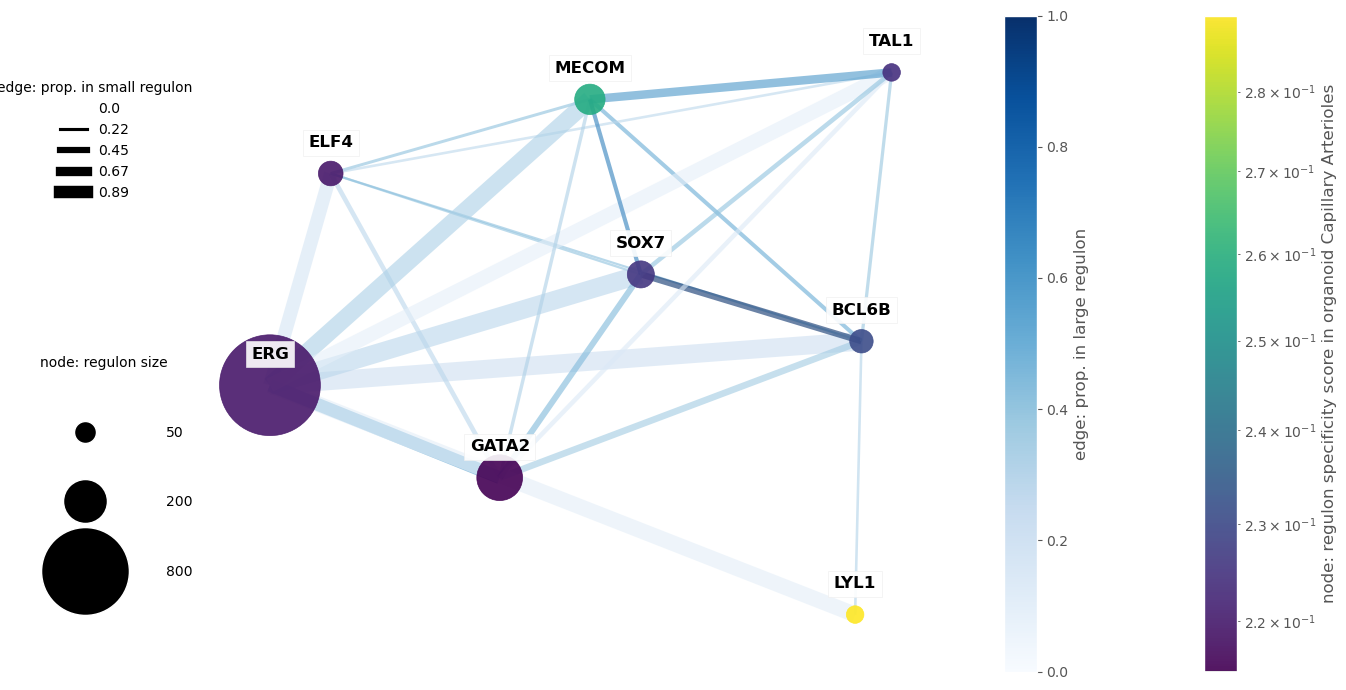

In [17]:
fig, ax = plt.subplots(figsize=(14,7))

sc = nx.draw_networkx_nodes(G=g,
                            pos = pos,
                            nodelist = g.nodes(),
                            alpha=0.9,
                            node_size = node_szs,
                            node_color = node_colors,
                            cmap='viridis')
nx.draw_networkx_labels(G=g,
                        pos = pos2,
                        font_weight='bold',
                        bbox=dict(facecolor='white', alpha=0.9),
                        labels=labeldict2)

nx.draw_networkx_edges(G = g, 
                       pos = pos,
                       edge_cmap = plt.cm.Blues,
                       edge_color = edgeColors,
                       width = edgeWidths,
                       alpha=0.6)

sc.set_norm(mcolors.LogNorm()) # log-scale colormap for better visualization and contrast
plt.colorbar(sc, label='node: regulon specificity score in organoid Capillary Arterioles')


# legend for edge color:
#--------------------

cmap = mpl.cm.Blues
norm = mpl.colors.Normalize() # (vmin=0, vmax=1)

plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             label='edge: prop. in large regulon')

# legend for edge thickness:
#--------------------

NUM_INTERVALS = 5
lines0 = np.linspace(min(edgeWidths)/15, max(edgeWidths)/15, NUM_INTERVALS)
line2ds = [Line2D([],[], linewidth=width*10, color='black') for width in lines0]
legend2 = plt.legend(line2ds,
                     np.round(lines0, decimals=2),
                     loc='lower right',
                     bbox_to_anchor=(0, 0.7),
                     frameon=False, # True,
                     title="edge: prop. in small regulon")
# legend for node sizes
sizes=[50,200,800]
points2ds = [Line2D([0],[0], color='w',markerfacecolor='black',marker='o',markersize =np.sqrt(s*5),label=s) for s in sizes]
legend3 = plt.legend(handles=points2ds,
                     loc='upper right',
                     bbox_to_anchor=(0, 0.5),
                     frameon=False, # True,
                     labelspacing=4,
                     handlelength=10,
                     title="node: regulon size")

plt.gca().add_artist(legend2)

ax.set_facecolor('white')
fig.set_facecolor('white')
plt.tight_layout()

plt.savefig('../../../figures/paper.figures/ext5l_pre_top6_noHOXD10.pdf',bbox_inches='tight')
#plt.close()

# check edge directions

In [18]:
rgenes = [r[:(len(r)-3)] for r in regulToGet]

In [19]:
# self
for i in range(0,len(rgenes)):
    for r in rgenes:
        if r in reglist[i]:
            if r==rgenes[i]:
                print(rgenes[i])

ELF4
ERG
GATA2
MECOM
TAL1


In [20]:
# dirs
for i in range(0,len(rgenes)):
    for r in rgenes:
        if r in reglist[i]:
            if r!=rgenes[i]:
                print(rgenes[i] + " -> " + r)

BCL6B -> ERG
BCL6B -> MECOM
ERG -> BCL6B
ERG -> ELF4
ERG -> GATA2
ERG -> LYL1
ERG -> MECOM
ERG -> SOX7
ERG -> TAL1
GATA2 -> BCL6B
GATA2 -> ERG
GATA2 -> MECOM
GATA2 -> SOX7
GATA2 -> TAL1
LYL1 -> ERG
MECOM -> BCL6B
MECOM -> TAL1
SOX7 -> ERG
TAL1 -> SOX7
